# Sequence alignment using edit distance


### and alignment module

You can get all optimal alignments w.r.t. edit distance with `EditDistanceComputer`. It is a subclass of `AlignmentComputer`. I had to create my own generic alignment computer for assignment 9 (structure superposition) because of the requirement of a specialized match function called with arguments allowing it identify a specific residue. It was not possible with BioPython's alignment library functions.

The alignment reconstruction is done by saving the optimal step(s) to a scoring matrix cell (`paths` matrix) during the computation of the scoring matrix. It wasn't possible to reconstruct the alignments in O(n+m) time just by using the scoring matrix when more complex gap/match score functions were employed (e.g. gap extensions vs gap opening). It could be done with this simple edit distance metric, but since I had to redo it anyway due to assignment 9, I replaced the old code (without saving the steps) with the generic alignment computer.

In [1]:
from assignments.edit_distance import EditDistanceComputer

alignments = EditDistanceComputer("clock", "overclocking").compute()
for al in alignments:
    print(al)
    print('distance:', al.distance)
    print()

----clock---
overclocking
distance: 7.0



In the case above and below there is only one optimal alignment (corresponding to the smallest distance, that is the least insert/delete/replace operations to turn one sequence into another).

In [2]:
alignments = EditDistanceComputer("clock", "lacks").compute()
for al in alignments:
    print(al)
    print('distance:', al.distance)
    print()

clock-
-lacks
distance: 3.0



There are more optimal alignments in the following example:

In [3]:
alignments = EditDistanceComputer("pitbull", "mr.worldwide").compute()

Yet not too many, so I it is possible to get all of them and put them into a list:

In [4]:
alignments = list(alignments)
print(f'There are {len(alignments)} optimal alignments: ')
print()

for al in reversed(alignments):  # it looks better when iterating in reverse
    print(al)
    print('distance:', al.distance)
    print()

There are 31 optimal alignments: 

pitbull-----
mr.worldwide
distance: 11.0

pitbu-ll----
mr.worldwide
distance: 11.0

pitb-ull----
mr.worldwide
distance: 11.0

pit-bull----
mr.worldwide
distance: 11.0

pi-tbull----
mr.worldwide
distance: 11.0

p-itbull----
mr.worldwide
distance: 11.0

-pitbull----
mr.worldwide
distance: 11.0

pitbu-l-l---
mr.worldwide
distance: 11.0

pitb-ul-l---
mr.worldwide
distance: 11.0

pit-bul-l---
mr.worldwide
distance: 11.0

pi-tbul-l---
mr.worldwide
distance: 11.0

p-itbul-l---
mr.worldwide
distance: 11.0

-pitbul-l---
mr.worldwide
distance: 11.0

pitbu-l--l--
mr.worldwide
distance: 11.0

pitb-ul--l--
mr.worldwide
distance: 11.0

pit-bul--l--
mr.worldwide
distance: 11.0

pi-tbul--l--
mr.worldwide
distance: 11.0

p-itbul--l--
mr.worldwide
distance: 11.0

-pitbul--l--
mr.worldwide
distance: 11.0

pitbu-l---l-
mr.worldwide
distance: 11.0

pitb-ul---l-
mr.worldwide
distance: 11.0

pit-bul---l-
mr.worldwide
distance: 11.0

pi-tbul---l-
mr.worldwide
distance: 11.0


# Processing FASTA files

BioPython library function `SeqIO.parse`, returns `SeqRecord` object already possessing the abilities required in this assignment: 

Read in a FASTA files with an arbitrary number of molecules. `parse_fasta` calls BioPython's `SeqIO.parse` and passes 'fasta' as the argument for file format. 

In [5]:
import os
from assignments.fasta import parse_fasta

seq_records = list(parse_fasta('assignments/fasta/test_data/seq1.fasta'))

seq_record = seq_records[0]

Obtain description/sequence of any molecules

In [6]:
print(seq_record.description)
print()
print(seq_record.seq)


NM_018189.3 Homo sapiens developmental pluripotency associated 4 (DPPA4), transcript variant 1, mRNA

AAGTGGGAGGAGACTTTGCAAATAGCAATCTTGGGGCAGGGGCCATTTTGGAAGCATGTTGCGAGGCTCCGCTTCTTCTACAAGTATGGAGAAGGCAAAAGGCAAGGAGTGGACCTCCACAGAGAAGTCGAGGGAAGAGGATCAGCAGGCTTCTAATCAACCAAATTCAATTGCTTTGCCAGGAACATCAGCAAAGAGAACCAAAGAAAAAATGTCTATCAAAGGCAGTAAAGTGCTCTGCCCTAAGAAAAAGGCAGAGCACACTGACAACCCCAGACCTCAGAAGAAGATACCAATCCCTCCATTACCTTCTAAACTGCCACCTGTTAATCTGATTCACCGGGACATTCTGCGGGCCTGGTGCCAACAATTGAAGCTGAGCTCCAAAGGCCAGAAATTGGATGCATATAAGCGCCTGTGTGCCTTTGCCTACCCAAATCAAAAGGATTTTCCTAGCACAGCAAAAGAGGCCAAAATCCGGAAATCATTGCAAAAAAAATTAAAGGTGGAAAAGGGGGAAACGTCCCTGCAAAGTTCTGAGACACATCCTCCTGAAGTGGCTCTTCCTCCTGTGGGGGAGCCGCCTGCCCTGGAAAATTCCACTGCTCTCCTTGAGGGAGTTAATACAGTTGTGGTGACAACTTCTGCCCCAGAGGCTTTGCTGGCCTCCTGGGCGAGAATTTCAGCCAGGGCGAGGACACCAGAGGCAGTGGAATCTCCACAAGAGGCCTCTGGTGTCAGGTGGTGTGTGGTCCATGGGAAAAGTCTCCCTGCAGACACAGATGGTTGGGTTCACCTGCAGTTTCATGCTGGTCAAGCCTGGGTTCCAGAAAAGCAAGAAGGGAGAGTGAGTGCACTCTTCTTGCTTCCTGCCTCCAATTTTCCACCCCCGCACCTT

Return sequence length for given sequence

In [7]:
len(seq_record.seq)

2823

Return subsequence of given sequence

In [8]:
seq_record.seq[2:10]

Seq('GTGGGAGG', SingleLetterAlphabet())

# Measuring sequence similarity using Hamming distance

In [9]:
from assignments.hamming import hamming_distance, IncompatibleLengthException

In [10]:
print(hamming_distance('abcd', 'abcd'))
print(hamming_distance('abcd', 'bbcw'))
print(hamming_distance('clock', 'lacks'))

seq_record = next(parse_fasta('assignments/fasta/test_data/seq1.fasta'))
print(hamming_distance(seq_record.seq, seq_record.seq))

0
2
5
0


Calling the function with two strings of different lengths raises an exception:

In [11]:
try:
    hamming_distance('ab', 'a')
except IncompatibleLengthException as e:
    print('Exception caught')

Exception caught


# Processing multiple sequence alignment

Written CLUSTAL  Parser based on http://meme-suite.org/doc/clustalw-format.html specs. It then instantiates `MSA`, which is a subclass of BioPython's `MultipleSeqAlignment` (sum of pairs computing functionality added).

Read and parse MSA.

In [12]:
from assignments.clustal_parser import parse_clustal

with open('assignments/clustal_parser/test_data/clustal_assigned') as f:
    msa = parse_clustal(f)

print(msa)

Alphabet() alignment with 55 rows and 530 columns
M-------------------------------------------...DSD UniRef90_A0A151
--------------------------------------------...DSE UniRef90_K7G3P4
--------------------------------------------...DSE UniRef90_UPI000
--------------------------------------------...GSE UniRef90_UPI000
--------------------------------------------...DSD UniRef90_L7NCR5
--------------------------------------------...DSD UniRef90_Q0GMA7
--------------------------------------------...DSD UniRef90_C0PUM1
--------------------------------------------...DSD UniRef90_UPI000
--------------------------------------------...DSD UniRef90_F5A7P3
--------------------------------------------...DSD UniRef90_O93379
--------------------------------------------...DSD UniRef90_Q9W678
--------------------------------------------...DSD UniRef90_UPI000
--------------------------------------------...DSD UniRef90_P25035
--------------------------------------------...DSD UniRef90_UPI000
------------

Retrieve sequence by its position (but not by ID which is not guaranteed to be unique, even in the assigned input data)

In [13]:
print(msa[0])

ID: UniRef90_A0A151
Name: UniRef90_A0A151
Description: UniRef90_A0A151
Number of features: 0
Seq('M-----------------------------------------------RQMESI...DSD')


Retrieve given column from the MSA

In [14]:
print(msa[:,60])

DGGGM--EMM--NNP-SSL-TNGSSSSSSSSGSSSSSSSGNNSTSSS-SSN-SD-


Retrieve sum of pairs score of a column and whole MSA with respect to given scoring matrix.

In [15]:
from Bio.SubsMat import MatrixInfo

scoring_matrix = MatrixInfo.blosum62

print('SoP column 60:', msa.sum_of_pairs_column(60, scoring_matrix))
print('SoP of the alignment:', msa.sum_of_pairs(scoring_matrix))

SoP column 60: 1113
SoP of the alignment: 1806364


#### Conservation determination from multiple aligned sequences

You should be able to specify a sequence in the MSA and the method would return conservation scores for the positions of the MSA.

In [16]:
print('SoP of a substring:', msa.sum_of_pairs(scoring_matrix, start_pos=50, end_pos=100))

SoP of a substring: 118727


Moreover, one should be able to identify top N scoring positions in the MSA.

In [17]:
print(msa.top_n_scoring_positions(10, scoring_matrix))


[(74, 15741), (218, 13365), (259, 13365), (328, 13365), (332, 13365), (368, 13365), (370, 13365), (224, 12771), (261, 11880), (283, 11880)]


Returns a list of tuples (position, score).

# Processing PDB files

There is a PDB file parser in BioPython library. However the returned objects, representing the structure do not meet all the 
requirements specified in this assignment. Therefore I extended the classes with the required functionality and made the parser use them. 

The parser returns a `Structure` object. A `Structure` always contains at least one `Model`. `Model` contains `Chain`s and they are 
composed of `Residue`s. These 4 objects are subclasses of `Entity` which provides behavior for this tree structure of objects (possible to
 enumerate children and to get the parent). 
 
 `Atom` is the bottom-most object in the hierarchy. 
 
 Each instance of the 5 types objects has a 
 unique id within its parent (not exactly `Structure` it does not have a parent). Forms of ids: `Model` – serial integer, corresponds to its 
 order in 
 the 
 file; 
 `Chain` – 
 standard one letter code; `Residue` – a triple of a hetero flag (`<space>` for no flag, 'W' for water, 'H' for hetatm), sequence number 
 (integer) and 
 insertion code (`<space>` or
  one 
 letter insertion code); `Atom` – atom 
 name ('CA').

Parse a PDB file and obtain the structure:

In [18]:
import assignments.pdb.pdb as pdb
from Bio.PDB import PDBParser

pdb.attach_custom_classes_to_pdb_structure_builder()

# quiet mutes parser's warning output
structure = PDBParser(QUIET=True).get_structure('1tup', 'assignments/pdb/test_data/1tup.pdb')

Get the c alpha atom of residue number 94 in chain A in the first model:

In [19]:
print(structure[0]['A'][(' ', 94, ' ')]['CA'])

<Atom CA>


Obtain an object representing a model, 
structure (chain) within a model,
residuum within a chain,
atom within a residue.

(Traversing the tree topology of `Structure` object.)

In [20]:
for model in structure:
    print(model)

    for chain in model:
        print(chain)
        print('number of residues in chain:', len(chain))
        
        for residue in chain:
            if residue.id[0].startswith('H_'):
                # is HETATM record
                
                for atom in residue:
                    print(atom.get_name())
                    print(atom.get_serial_number())
                
                print(residue.id)

<Model id=0>
<Chain id=E>
number of residues in chain: 43
<Chain id=F>
number of residues in chain: 35
<Chain id=A>
number of residues in chain: 395
ZN
5447
('H_ ZN', 951, ' ')
<Chain id=B>
number of residues in chain: 265
ZN
5448
('H_ ZN', 952, ' ')
<Chain id=C>
number of residues in chain: 276
ZN
5449
('H_ ZN', 953, ' ')


Obtain information about the stored structure (number of models, structures, residues, atoms).

In [21]:
print(structure.count_chains)
print(structure.count_atoms)
print(structure[0]['A'].count_residues)

5
5828
395


<a id='structure_width_cell'></a>

Compute the width of the structure – maximum of distance of any two atoms. Takes some time: naive 
$\Theta (\text{#atoms}^2)$ algorithm.


In [22]:
print(pdb.structure_width(structure))


110.07378


Obtain list of atoms or residues being in given distance from given ligand (HETATM)

In [23]:
hetero_atoms = list(pdb.get_hetero_atoms(structure))
hetatm = hetero_atoms[0]

print(pdb.atoms_within_d_to_atom(structure, hetatm, 10))
print(pdb.residues_within_d_to_atom(structure, hetatm, 10))

[(<Atom O5'>, 0.0), (<Atom C5'>, 1.4344189), (<Atom C4'>, 2.4593778), (<Atom CG>, 3.2323287), (<Atom C3'>, 3.3550873), (<Atom O3'>, 3.5640006), (<Atom CB>, 3.6176894), (<Atom O4'>, 3.6445122), (<Atom CA>, 3.932097), (<Atom OG>, 4.161508), (<Atom NE>, 4.4037905), (<Atom CD>, 4.4146547), (<Atom CZ>, 4.4770985), (<Atom NH1>, 4.5479546), (<Atom C2'>, 4.714053), (<Atom C1'>, 4.7431073), (<Atom O>, 4.804691), (<Atom C>, 4.83322), (<Atom N>, 4.8675723), (<Atom CA>, 4.912375), (<Atom CB>, 4.9665666), (<Atom NH2>, 5.051013), (<Atom P>, 5.0910726), (<Atom O>, 5.117413), (<Atom N>, 5.2062144), (<Atom C>, 5.2719526), (<Atom OP1>, 5.477591), (<Atom NH2>, 5.673154), (<Atom O>, 5.730959), (<Atom OP2>, 5.7604446), (<Atom NE>, 5.8461447), (<Atom CZ>, 5.884168), (<Atom O5'>, 5.885547), (<Atom CB>, 5.919022), (<Atom C>, 5.946488), (<Atom N>, 5.991925), (<Atom N1>, 6.013206), (<Atom C>, 6.149049), (<Atom CA>, 6.155915), (<Atom C6>, 6.2738433), (<Atom O>, 6.290737), (<Atom O>, 6.307814), (<Atom NH1>, 6.538

# Computing structure-related properties

The essential part of this assignment – decision if a particular residue is on surface of, or buried in the protein – can be outsourced
 to a library method, or one can provide their own method. I have decided to come up with a couple methods myself and compare them with 
 the library method. 
 
 The library method is installed as a standalone program (instr. in repository's README), but it has a Python wrapper in the BioPython 
 library that makes it work with BioPython's structure objects. Original program description follows:

> In a first step, a probe sphere representing a solvent molecule is rolled over the set of spheres, 
> defining the Reduced Surface (RS). From the reduced surface the analytical model of the Solvent Excluded Surface (SES) is computed. 
> This analytical surface can be triangulated with a user specified vertex density.

The set of spheres (coordinates+radii) is generated from the structure's atoms by the BioPython wrapper and passed as the program's input. 
The surface is triangulated and returned to the BioPython's wrapper and one can then ask, for example, what is the average depth of a 
residue (average distance of residue's atoms to the surface) or for the c_alpha depth. 
At the time I did the programming, most sense for me made determining minimum depth of residue's atoms. The residue should 
have at least one atom on/close to the triangulated surface – then it could be classified as a surface residue.

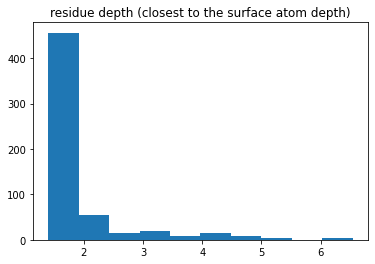

In [24]:
import os
from matplotlib import pyplot as plt
from Bio.PDB import PDBParser, ResidueDepth, get_surface
from Bio.PDB.ResidueDepth import min_dist

from assignments.pdb.pdb import attach_custom_classes_to_pdb_structure_builder

attach_custom_classes_to_pdb_structure_builder()
structure = PDBParser(QUIET=True).get_structure('1tup', 'assignments/structure_related_properties/test_data/1tup.pdb')

model = next(structure.get_models())


from assignments.structure_related_properties.lib import get_model_without_waters

# model without hoh for surface analysis (not interested in surface of solvation (water) layer!, only protein)
model_without_waters = get_model_without_waters(model)
cp_to_original_residue = lambda r: model[r.get_parent().id][r.id]  # gets the corresponding residue in the original model

residue_depth = ResidueDepth(model_without_waters)

avg_residue_depth = {cp_to_original_residue(r): r_d for r, (r_d, calpha_d) in residue_depth}
calpha_residue_depth = {cp_to_original_residue(r): calpha_d for r, (r_d, calpha_d) in residue_depth}

surface = get_surface(model_without_waters)    
min_dist_to_surface = {r: min(min_dist(atom.get_coord(), surface) for atom in r) for r in model.aa_residues}

plt.hist(min_dist_to_surface.values())
plt.title('residue depth (closest to the surface atom depth)')
plt.show()

Note that the residue depth does not start at 0 angstroms. That's because the returned surface is based on the surface of the _spheres_, centered at atoms' coordinates (and depth is the distance to the surface from the atom coordinates). They have different radii, depending on atom type, mostly between 1 and 2 angstroms.

For evaluating the structural neighborhood of residues I chose to count in its surroundings: water molecules, residues and atoms. 

The last two methods in the following code differ from the others a little – of all residue's atom choose the atom with minimum neighbors and return the count for that residue. They have the best correlation with residue's depth measured by the library (will be seen later).

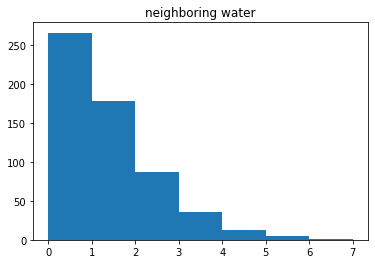

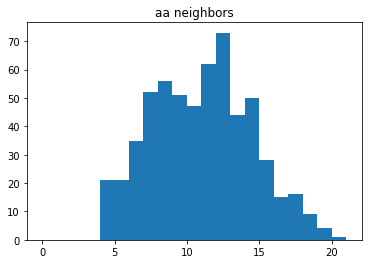

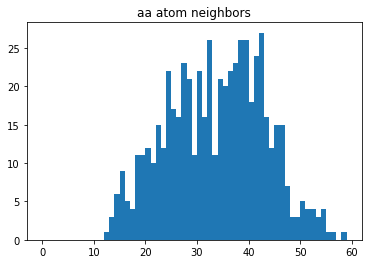

In [25]:
from assignments.structure_related_properties.lib import *

neighboring_water_counts = residues_get_neighboring_water_count(model, model.aa_residues, 3.5)
histogram_counts(neighboring_water_counts.values(), 'neighboring water')

neighbor_counts = residues_get_neighbor_count(model.aa_residues, 5)
histogram_counts(neighbor_counts.values(), 'aa neighbors')

neighbor_atom_counts = residues_get_neighbor_atom_count(model.aa_residues, 4.5)
histogram_counts(neighbor_atom_counts.values(), 'aa atom neighbors')

ratio_water_aas = {res: wc/ac for res, (wc, ac) in zip_mappings(neighboring_water_counts, neighbor_counts)}
ratio_water_aa_atoms = {res: wc/aac for res, (wc, aac) in zip_mappings(neighboring_water_counts, neighbor_atom_counts)}

residues_min_neighbor_residues_count = residues_get_min_neighbor_residues_count(model.aa_residues, 8.5)
residues_min_neighbor_atoms_count = residues_get_min_neighbor_atoms_count(model.aa_residues, 8.5)

I measured correlation of those structural-neighborhood methods with the results from the surface-computing library.

In [26]:
vars = np.transpose([values for k, values in zip_mappings(
        # based on surface computing program
        avg_residue_depth,
        calpha_residue_depth,
        min_dist_to_surface,

        # my variables
        neighboring_water_counts,
        neighbor_counts,
        neighbor_atom_counts,
        ratio_water_aas,
        ratio_water_aa_atoms,

        residues_min_neighbor_residues_count,
        residues_min_neighbor_atoms_count
    )])

np.set_printoptions(linewidth=200)  # for the large correlation matrix
print(np.corrcoef(vars))

[[ 1.          0.93086292  0.90785399 -0.06946207  0.6466452   0.52544156 -0.196897   -0.17374748  0.68933673  0.70641204]
 [ 0.93086292  1.          0.8087332  -0.01853723  0.62770217  0.51602029 -0.15658783 -0.12606481  0.62502189  0.64725568]
 [ 0.90785399  0.8087332   1.         -0.09348417  0.46227425  0.34576639 -0.16743996 -0.14855346  0.54564509  0.56600764]
 [-0.06946207 -0.01853723 -0.09348417  1.          0.00691785 -0.04818904  0.8916267   0.91951683 -0.05484552 -0.07255066]
 [ 0.6466452   0.62770217  0.46227425  0.00691785  1.          0.80075761 -0.26017425 -0.18944177  0.7896488   0.7805114 ]
 [ 0.52544156  0.51602029  0.34576639 -0.04818904  0.80075761  1.         -0.26205451 -0.29024273  0.61527546  0.65416953]
 [-0.196897   -0.15658783 -0.16743996  0.8916267  -0.26017425 -0.26205451  1.          0.95758862 -0.26016253 -0.27827227]
 [-0.17374748 -0.12606481 -0.14855346  0.91951683 -0.18944177 -0.29024273  0.95758862  1.         -0.20242197 -0.22961092]
 [ 0.68933673  0

The last two methods have the best correlation. However that's not the best metric for comparison, see below.

The neighboring-water-molecules method does have some results (better seen on the scatter plot below). But 1) just by looking at the structure it's not like the surface is consistently covered with water molecules (probably because of the method – X-ray _crystallography_). However, one might think that at least presence of HOH in neighborhood might indicate that a residue is a surface one. Even this is not the case always, as during chain oligomerization, water molecules get trapped between the chains, thus not on the surface of protein (ok, on the surface of _chains_). In addition, they are also trapped inside the chain, during polypeptide folding (1tup.A.173 valine – three HOH within 3.5 Å, but not on surface of model or chain). The method is not therefore very useful in deciding whether a residue is on surface or not.

I decided to also inspect the results with a scatter plot of my and library's methods of rate of 'buriedness'.
Provided that the library method is correct enough, with a good method I should see two clusters (surface and buried), that can be 
    demarcated by two perpendicular lines (each parallel to an axis), this cross would divide the datapoints into four quadrants and 
    ideally,
     only quadrants I (buried) and III (surface) would be occupied, provided that both axes show rate of 'buriedness'.

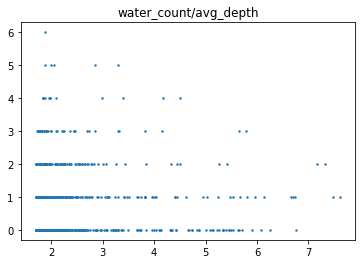

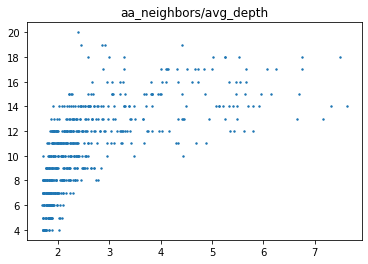

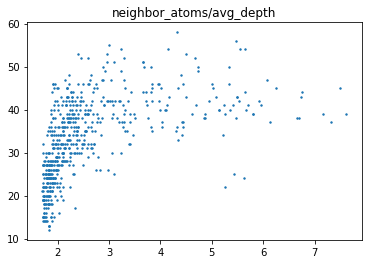

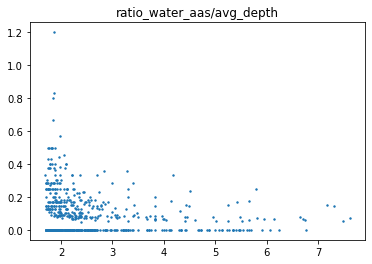

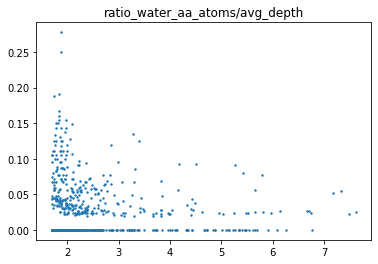

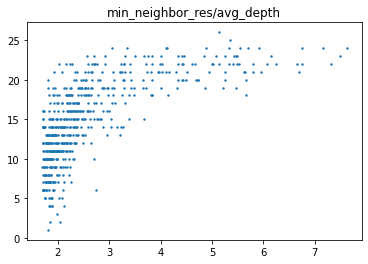

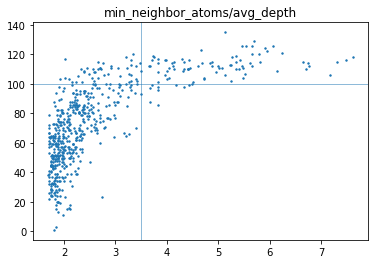

In [27]:
scatter(avg_residue_depth, neighboring_water_counts, 'water_count/avg_depth')
scatter(avg_residue_depth, neighbor_counts, 'aa_neighbors/avg_depth')
scatter(avg_residue_depth, neighbor_atom_counts, 'neighbor_atoms/avg_depth')
scatter(avg_residue_depth, ratio_water_aas, 'ratio_water_aas/avg_depth')
scatter(avg_residue_depth, ratio_water_aa_atoms, 'ratio_water_aa_atoms/avg_depth')
scatter(avg_residue_depth, residues_min_neighbor_residues_count, 'min_neighbor_res/avg_depth')
plt.axvline(x=3.5, lw=0.5)  # some values, just to divide the plot into those quadrants
plt.axhline(y=100, lw=0.5)
scatter(avg_residue_depth, residues_min_neighbor_atoms_count, 'min_neighbor_atoms/avg_depth')

The last two are most promising. However there are some outliers, that would be classified with library method as surface, with mine as 
buried and vice versa. I tuned the parameter – radius of the neighborhood – with visual inspection of scatters (looking for the two 'rectangular' clusters 
meeting with a corner). I did inspect both types of the outliers, but I don't really remember 
the results and it is probably out of scope for this homework. Nevertheless, I will point out some problems I see with the methods.

A problem with the atom-count-in-neighborhood is the variability of the value when a surface residue is in cavities/grooves or on 
the contrary on pointing-out loops. The virtual surface label is the same however.

The problem with the library method (that gets the protein surface and depths of residues) is in how it corresponds to the actual idea of 
deciding whether a residue is surface or buried. In hindsight, I should have had unequivocally defined what a surface residue is – one of its atom spheres touches, or rather contributes _a minimum amount of surface_ to the solvent accessible surface. That's not quite the residue depth, in any of the three variants I have obtained from the library. 

Unless the touching is enough. In that case, `min_dist_to_surface` would be probably the best method to decide if the residue is surface or buried and I will therefore use it as the arbiter in the following tasks. I set the boundary to 2.3 Å, by looking at the residues in PyMOL.

A scatterplot similar to the last one follows (also shows `residues_min_neighbor_atoms_count`), although not with average depth of the residue, but with the minimum depth of its atoms. I added the mentioned surface/buried boundary.

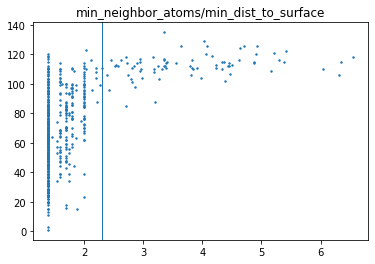

In [28]:
plt.axvline(x=2.3, lw=1)  # boundary surface/buried
scatter(min_dist_to_surface, residues_min_neighbor_atoms_count, 'min_neighbor_atoms/min_dist_to_surface')

### Actual tasks

Compute the diameter of the protein – the [solution](#structure_width_cell) is already in assignment Processing PDB files.

Compute the ratio of surface and buried amino acids:

In [29]:
is_surface_fn = lambda aa: is_surface(min_dist_to_surface, aa)

ratio_surface_to_buried = get_ratio_surface_to_buried(model, is_surface_fn)
print('surface/buried: ', ratio_surface_to_buried)

surface/buried:  6.5


Output a histogram of amino acids composition of buried and exposed amino acids.

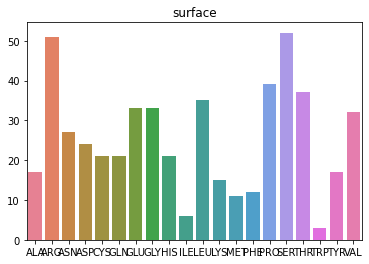

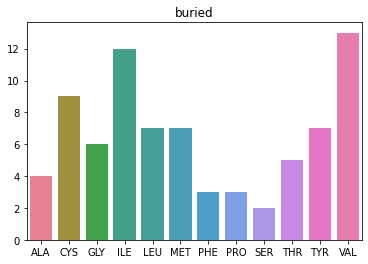

In [30]:
aa_types_surface = get_aa_counts(filter(is_surface_fn, model.aa_residues))
aa_types_buried = get_aa_counts(filter(lambda aa: not is_surface_fn(aa), model.aa_residues))

import seaborn as sns
# one palette for both histograms
aa_types = sorted(set(itertools.chain(aa_types_surface, aa_types_buried)))
palette = dict(zip(aa_types, sns.color_palette('husl', len(aa_types))))

sns.barplot(*np.transpose(sorted(aa_types_surface.items())), palette=palette).set_title('surface')
plt.show()

sns.barplot(*np.transpose(sorted(aa_types_buried.items())), palette=palette).set_title('buried')
plt.show()

(The plots are smaller than they should be (6x4 inches by default), jupyter notebook scales it down, it's probably a bug. Run the following line and redraw the plots to render them bigger. It's a hack and the text and markers are still scaled down.)

In [31]:
# plt.rcParams['figure.figsize'] = [12, 8]

Quantify portion of polar amino acids in the core and on the surface of the protein. 

In [32]:
for aa_counts, location_str in ((aa_types_buried, 'buried'), (aa_types_surface, 'surface')):
    polar_count = count_polar_aas(aa_counts)

    print(f'Ratio of polar aas {location_str}: ', polar_count/sum((count for count in aa_counts.values())))

Ratio of polar aas buried:  0.2564102564102564
Ratio of polar aas surface:  0.7297830374753451


Use the structures of A2a and caffeine receptor and hemoglobin (1b0b) to quantify the portion surface and buried amino acids and also the portion of polar amino acids from previous task. Do you see any significant differences? If so, try to interpret them. 

In [33]:
a2a = PDBParser(QUIET=True).get_structure('A2a receptor', 'assignments/structure_related_properties/test_data/A2a_receptor.pdb')
hemo = PDBParser(QUIET=True).get_structure('hemoglobin', 'assignments/structure_related_properties/test_data/hemoglobin(1b0b).pdb')

results = defaultdict(dict)

for struct in (a2a, hemo):
    model = struct[0]

    surface = get_surface(get_model_without_waters(model))
    min_dist_to_surface = {r: min(min_dist(atom.get_coord(), surface) for atom in r) for r in model.aa_residues}
    is_surface_fn = lambda aa: is_surface(min_dist_to_surface, aa)

    results[struct]['Ratio surface/buried'] = get_ratio_surface_to_buried(model, lambda aa: is_surface(min_dist_to_surface, aa))

    aa_types_surface = get_aa_counts(filter(is_surface_fn, model.aa_residues))
    aa_types_buried = get_aa_counts(filter(lambda aa: not is_surface_fn(aa), model.aa_residues))

    for aa_counts, location_str in ((aa_types_buried, 'buried'), (aa_types_surface, 'surface')):
        polar_count = count_polar_aas(aa_counts)

        results[struct][f'Ratio of polar aas {location_str}'] =  polar_count / sum((count for count in aa_counts.values()))

import pprint
pprint.pprint(results)

defaultdict(<class 'dict'>,
            {<Structure id=A2a receptor>: {'Ratio of polar aas buried': 0.5945945945945946,
                                           'Ratio of polar aas surface': 0.49264705882352944,
                                           'Ratio surface/buried': 7.351351351351352},
             <Structure id=hemoglobin>: {'Ratio of polar aas buried': 0.21052631578947367,
                                         'Ratio of polar aas surface': 0.7967479674796748,
                                         'Ratio surface/buried': 6.473684210526316}})


__Polarity of amino acids on the surface__

Hemoglobin I from clam LUCINA PECTINATA is a monomeric soluble protein. In the clam it is dissolved in a polar fluid hemolymph. Therefore, its surface is predominantly made of polar amino acids (80%).

A2a is a G protein-coupled receptor. It contains 7 transmembrane alpha-helices. Its surface is therefore to a large extent in contact with aliphatic chains of phospholipids of lipid bilayer. At those hydrophobic sites, surface is made of compatible hydrophobic amino acids.

The receptor also has cytosolic and extracellular parts (thus will also have polar surface there). 

On the surface of the receptor, as in the crystal structure, we have identified half polar and half non-polar amino acids, no conflict with the reasoning above.

__Polarity of amino acids in the core__

Hemoglobin has a great ratio of hydrophobic residues in the core. The inner sides of alpha-helices have hydrophobic residues which allow for the protein to fold in a globule in a polar medium.

However, A2a receptor has a surprisingly high number of polar residues in the core. That might be to hold the transmembrane helices together in the hydrophobic membrane. Mechanism of receptor's working is a conformational change initiated from outside of the membrane propagating to the intracellular part. That might be a delicate process and predictable structure/orientation of the transmembrane helices might be needed. In a hydrophobic medium, that might be achieved by polar interactions. Also, it seems to me, that polar interactions can be more accurate in this than not-so-specific hydrophobic interactions.

__Ratio of counts of surface/buried amino acids__

Hemoglobin has a lower ratio of surface to buried amino acids (6.5 vs 7.4 in A2a). It's a globular protein, thus given its volume, its surface is close to minimal. 

A2a has more elongated, barrel, shape (passes through membrane) and one shorter and one longer non-transmembrane helices, which 'poke' out of the structure. That combined increases the surface/buried counts ratio.

# Combining structure and sequence

In this assignment, we implement a tool which considers user-provided structure and multiple sequence alignment (where one of the sequences corresponds to the provided structure) and show that positions corresponding to the active site are relatively highly conserved. 

In [34]:
import itertools

from Bio.PDB import PDBParser

from assignments.clustal_parser import parse_clustal
from assignments.pdb.pdb import get_hetero_atoms, residues_within_d_to_atom, attach_custom_classes_to_pdb_structure_builder

# Read and parse MSA.
with open('assignments/combining_structure_sequence/test_data/clustal_assigned') as f:
    msa = parse_clustal(f)

# load structure, get the model
attach_custom_classes_to_pdb_structure_builder()
model = PDBParser(QUIET=True).get_structure('1tup', 'assignments/combining_structure_sequence/test_data/1tup.pdb')[0]

The structure for this analysis is human tumor suppressor p53 (or the DNA-binding domain) complexed with DNA. The PDB structure file contains three protein chains (homotetrameric in vivo) and two DNA chains.

In the MSA, there is a sequence that designates the protein chain (the three chains are identical in sequence). We can therefore run the analysis with any of the polypeptide chains. 

I will run the analysis for all chains at once, but one may easily modify the snippet below to run it for a specific chain.

In [35]:
from assignments.combining_structure_sequence.main import *

msa_seq = next(filter(lambda seq_record: 'UniRef90_P04637' == seq_record.id, msa)).seq
resseq_to_msa_columns = get_resseq_to_msa_columns(msa_seq)  # mapping from structure's residue's sequence identifier

# check that sequences from MSA and structure correspond in amino acids
for chain_letter in ('A', 'B', 'C'):
    chain = model[chain_letter]
    assert_chain_aas_correspond_to_msa_seq_aas(list(chain.aa_residues), msa_seq, resseq_to_msa_columns)

entity = model  # combines the three polypeptide chains into the dataset at once
# entity = model['A'] -- would run the analysis for chain A

We will gather all residues that form active sites. That is, they have a hetero atom (small ligand, DNA) within a set distance. 

In [36]:
HETATM_WITHIN_A = 2.5  # set 4 angstroms for DNA binding (donor to acceptor, hydrogen non existent in X-ray structures)

hetero_atoms = list(get_hetero_atoms(model))  # note that the whole `model`, not the single chain 
                                              # -- in case we want to include nucleotides (have their own chains)
active_site_residues = set()

for hetatm in hetero_atoms:
    residues_and_distances = residues_within_d_to_atom(entity, hetatm, HETATM_WITHIN_A)  
    
    active_site_residues.update(r for r, d in residues_and_distances if r.is_aa)
    
    # debug print residues close to a nucleotide
    if len(hetatm.get_parent()) != 1:
        # is not one atom hetatm residue (Zn), but probably a nucleotide
        for r, d in residues_and_distances:
            if r.is_aa:
                print(r)


non_active_site_residues = list(set(entity.aa_residues).difference(active_site_residues))
active_site_residues = list(active_site_residues)  # making it list, next code depends on the order

<Residue LYS het=  ch=B resseq=120 icode= >


The debug print tells us that just one of the active-site residues within 2.5 angstroms to a hetatm is close to a nucleotide.

Finally, we will get the conservation rates (SoP score) for the two groups and plot the results.

avg conservation active:  12387.153846153846
avg conservation non-active:  6127.706293706294


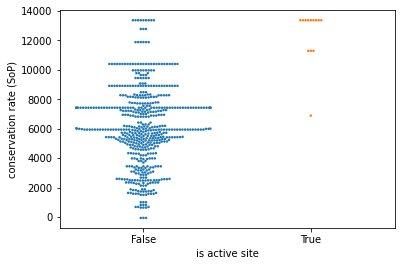

In [37]:
conservation_active = [conservation_rate_of_chain_aa(msa, aa, resseq_to_msa_columns)
                       for aa in active_site_residues]

conservation_non_active = [conservation_rate_of_chain_aa(msa, aa, resseq_to_msa_columns)
                           for aa in non_active_site_residues]

import matplotlib.pyplot as plt
import seaborn as sns

print('avg conservation active: ', sum(conservation_active)/len(conservation_active))
print('avg conservation non-active: ', sum(conservation_non_active)/len(conservation_non_active))

ax = sns.swarmplot(
    x=list(itertools.chain(itertools.repeat(False, len(non_active_site_residues)), itertools.repeat(True, len(active_site_residues)))),
    y=list(itertools.chain(conservation_non_active, conservation_active)),
    size=2.5
)
ax.set(xlabel='is active site', ylabel='conservation rate (SoP)')
plt.show()

We can indeed see relatively higher conservation for the residues forming the active sites. One residue is lower in conservation and that's the only DNA binding residue we get with the 2.5 angstroms setting. All but one active site residues are zinc-binding residues. Zinc is important for the structure of the DNA-binding domain. In all of the homologs of p53 (from different organisms, that's what seems to be in the clustal file).

If we run the analysis with 4 angstroms, we start to see more DNA-binding residues. However, their conservation rate is usually lower than of those zinc-binding, it's close to the average of all structure's residues. I looked up if p53 binds to a consensus sequence and it does. But it is not probably the same in all those organisms. The smaller conservation rate could make sense in that DNA undergoes mutations constantly. And such an important protein must mutate with it accordingly (the binding residues), in order for organisms with the mutation to thrive/survive.



# Structure superposition

To superimpose two structures, we will find a mapping between the structures' residues. Then we will translate and rotate one structure, so that the two residues in a pair (from the mapping) are as close to each other as possible. This is achieved by Kabsch algorithm, which calculates the optimal rotation matrix, given a set of point pairs. Usually, residues are represented, as points, by its c alpha coordinates.

Finally we will compare calculated superpositions a) where the residues' mapping is obtained by standard sequence alignment, and b) where the mapping-determining sequence alignment has a scoring function that also considers structural neigborhood of the residues. The superpositions will be compared by means of RMSD, that is root-mean-square deviation (of the atom coordinates).

First we'll load the two similar structures. I had to choose the most similar structure (from nr-PDB-90 database), which is also an A2a receptor (human), but with a ligand, because the other structures were too dissimilar (I got 20+ RMSD with just sequence alignment and adding structural features didn't really help).

Both are single chain structures, so we will be superimposing just those two chains based on alignment of the polypeptides. If we were to superimpose a multimeric protein, we would have to map their corresponding chains, run the alignment for each chain pair and combine the matched c alphas into one point-pair set, which would be used to calculate the optimal rotation, so that RMSD is minimized. 

In [38]:
from Bio.PDB import PDBParser

from assignments.structure_superposition.superposition import *

parser = PDBParser()
chain1 = parser.get_structure('a2a', 'assignments/structure_superposition/test_data/A2a_receptor.pdb')[0]['A']
chain2 = parser.get_structure('3eml', 'assignments/structure_superposition/test_data/3eml.pdb')[0]['A']

superposition_rmsds = []

The last line initializes a container for superposition RMSD's that we'll use and discuss in the comparison at the end. Another output of this program will be the superimposed structures. More precisely just the first 'a2a' structure with altered coordinates to fit to the orignal '3eml' structure. 

Thus to see the alignments in PyMOL, for example, load the original '3eml' structure and then the output files (in the working directory) named 'a2a_&lt;alignment method&gt;.pdb'

The following snippet will generate the superposition based on standard sequence alignment. We use Blosum62 scoring matrix and implemented variable gap penalty (opening, extension and end gaps).

In [39]:
def superposition_with_blosum(chain1, chain2, alignment):
    chain1 = chain1.copy()  # will change atom coordinates, so create a new object
    pp1, pp2 = map(chain_to_one_pp, (chain1, chain2))

    superposition_calphas = superimpose_chain(chain1, pp1, pp2, alignment)

    save_structure(single_chain_structure(chain1), 'a2a_blosum_alignment.pdb')
    print(superposition_calphas.calculate_rmsd(), superposition_calphas.matched_residues_count)
    
    superposition_rmsds.append(('blosum_al', list(get_rmsd_sequence_of_superposition(superposition_calphas))))

pp1, pp2 = map(chain_to_one_pp, (chain1, chain2))
als = Blosum62AlignmentComputer(pp1.get_sequence(), pp2.get_sequence()).compute()

# there might be thousands of optimal alignments, take only one (the next ones could be very similar, so it doesn't make sense to
# include just n first, not representative anyway)
al = next(als)

superposition_with_blosum(chain1, chain2, al)

warning  2  polypeptides from one chain, extending first pp
warning  2  polypeptides from one chain, extending first pp
warning  2  polypeptides from one chain, extending first pp
warning  2  polypeptides from one chain, extending first pp
7.94679558123895 288


Next, we'll employ also structural features in the sequence alignment step. We could use any neighborhood function from assignment [Combining structure and sequence](#Combining-structure-and-sequence). I randomly chose `residues_get_min_neighbor_atoms_count`. 

The problem was how to come up with a metric that would take two residues and return a structural score to take it into account during the seq. alignment computation. I could have taken the difference and scale it, for example divide it by maximum range, spread, between the residue's neighborhood values in both structures, to obtain 0 in the best case and 1 in the worst. 

Better, the distribution of neighborhood values can be captured in the metric, if we combined the sets of neighborhood values for residue from both structures and sorted the resulting list, then when asked for a score for struct1.res1 and struct2.res2 we would just count the residues with values in between. The count can then be scaled down by the total count of residues to a number in [0, 1]. Maybe it would be beneficial to aggregate the data from more structures, but I chose this simple approach.

In the code below, we output multiple superpositions, each is based on a an seq. alignment with a different weight for the structural score of to-be matched residues. The alignment computer is otherwise derived from the `Blosum62AlignmentComputer` used above.

In [40]:
def superposition_with_blosum_and_structural_features(chain1, chain2):
    polypeptide1, polypeptide2 = map(chain_to_one_pp, (chain1, chain2))

    residues_min_neighbor_count = residues_get_min_neighbor_atoms_count(polypeptide1, 8.5)
    residues_min_neighbor_count.update(residues_get_min_neighbor_atoms_count(polypeptide2, 8.5))

    min_neighbor_res_count_metric = StructuralFeatureMetric(residues_min_neighbor_count)

    for structural_score_weight in (0.5, 1, 2, 3, 4, 10, 2000):
        print('processing weight', structural_score_weight)

        als = StructuralFeaturesSequenceAlignmentComputer(polypeptide1.get_sequence(),
                                                          polypeptide2.get_sequence(),
                                                          polypeptide1,
                                                          polypeptide2,
                                                          [(min_neighbor_res_count_metric, structural_score_weight)],
                                                          1).compute()
        
        # structural alignments like this have usually just one optimal alignment, just to see it ourselves:
        als = list(als)
        print('no of als: ', len(als))
        alignment = als[0]

        ch1 = chain1.copy()  # deep copying  chain1, because we will alter the coordinates to form the superposition
        pp1, pp2 = map(chain_to_one_pp, (ch1, chain2))

        superposition_calphas = superimpose_chain(ch1, pp1, pp2, alignment)

        save_structure(single_chain_structure(ch1), f'a2a_blosum_alignment_structural_features_{structural_score_weight}.pdb')
        print(superposition_calphas.calculate_rmsd(), superposition_calphas.matched_residues_count)

        superposition_rmsds.append((f'blosum_struct_al{structural_score_weight}',
                                    list(get_rmsd_sequence_of_superposition(superposition_calphas))))


superposition_with_blosum_and_structural_features(chain1, chain2)

warning  2  polypeptides from one chain, extending first pp
warning  2  polypeptides from one chain, extending first pp
processing weight 0.5
no of als:  1
warning  2  polypeptides from one chain, extending first pp
warning  2  polypeptides from one chain, extending first pp
5.003725297930205 288
processing weight 1
no of als:  1
warning  2  polypeptides from one chain, extending first pp
warning  2  polypeptides from one chain, extending first pp
5.003725297930205 288
processing weight 2
no of als:  1
warning  2  polypeptides from one chain, extending first pp
warning  2  polypeptides from one chain, extending first pp
5.003725297930205 288
processing weight 3
no of als:  1
warning  2  polypeptides from one chain, extending first pp
warning  2  polypeptides from one chain, extending first pp
5.003725297930205 288
processing weight 4
no of als:  1
warning  2  polypeptides from one chain, extending first pp
warning  2  polypeptides from one chain, extending first pp
5.003725297930205 28

The comparison of the superpositions follows. Besides looking at the output structures in PyMOL and checking the RMSDs and matched residues count, I wanted to compare the superpositions even if the matched residues count is different. Is a superposition with 150 matched residues and RMSD of 5 angstroms better than a superposition with 200 matched residues and RMSD of 7.5 angstroms? What if some residues are matched (unfortunately), and their deviation is enormous in comparison to the rest of residues, which would make on their own a good superposition with good RMSD?

Therefore I decided to generate a sequence of RMSDs for a superposition, n-th item computed as an RMSD of n atom pairs with the lowest deviation of all superposition's pairs. In the line plot below, you can see the RMSD sequences for all the superpositions computed above. 

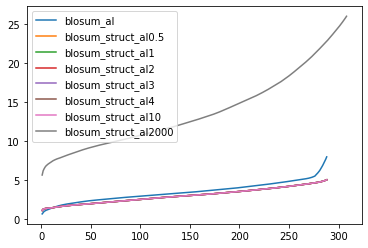

In [41]:
import seaborn as sns
from matplotlib import pyplot as plt

x, y = np.transpose(list(itertools.chain(*(enumerate(values, start=1) for name, values in superposition_rmsds))))

sns.lineplot(x=x, y=y, hue=[name for name, values in superposition_rmsds for _ in values])
plt.show()

We see that the structural neighborhood alone (at least the single method tested) does not produce a good superposition (`blosum_struct_al2000`, substitution matrix scores negligible in comparison with the 2000x scaled structural score). 

However, reasonably weighing in the structural neighborhood in the standard sequence alignment with Blosum62 (in the hindsight with those particular structures I probably should have used a higher similarity matrix), lead to a superposition that had significantly lower RMSD that of just standard sequence alignment (5 vs 8 angstroms), with the same number of matched residues (288).

In the chart we can see that the problem with `blosum_al` is that there are a few residues that are an unfortunate match. Other than that superposition would have a similar RMSD to the structure-weighed-in-alignment superpositions.

Looking in PyMOL, one cannot really see much difference between the 5 Å RMSD superpositions and the 8 Å `blosum_al`. That might be because a shift in matching residues in a occurred (gaps moved) and suddenly paired residues were more far apart (in a different turn in a helix or further in a loop), but somehow the shift didn't have much rotational and translational potential. Comparison of the sequence alignments and observation of the residues having the largest deviation in PyMOL would explain it more properly.